In [1]:
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 18.8 MB/s eta 0:00:0000:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import cv2
import easyocr

from skimage.filters import threshold_local
from PIL import Image
from ultralytics import YOLO

import re

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
model = YOLO('/kaggle/input/yolo-final/bestYolo8m_50epochs_good_dataset.pt')

In [5]:
drivers = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_Drivers/Drivers'
pts = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_PTS/PTS'
passports = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_Passports/Passports'
sts = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS'

In [6]:
album = ['udov_front', 'udov_back', 'passport_front']
book = ['pts', 'sts_front', 'sts_back', 'passport_back']

In [7]:
def yolo_predict(model, img):
    res = []
    results = model.predict(img, stream=True) 
    
    for result in results: 
        boxes = result.boxes.cpu().numpy()
        for box in boxes:
            r = box.xyxy[0].astype(int)
            class_id = int(box.cls[0])
            class_name = model.names[class_id]
            scores = box.conf[0]
            res.append((class_name, scores, r))
            
    return res

In [8]:
def crop_image(image, bbox):
    x1, y1, x2, y2 = bbox
    cropped_image = image[y1:y2, x1:x2]
    return cropped_image

In [9]:
def compare_white_pixels(image):
    width = image.shape[1]
    left_region = image[:, :int(width / 2)]
    right_region = image[:, int(width / 2):]

    left_white_pixels = np.sum(left_region == 255)
    right_white_pixels = np.sum(right_region == 255)
        
    return left_white_pixels > right_white_pixels

In [10]:
def rotate_to_book(image):
    height, width = image.shape[:2]
    
    if width > height:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        
#     image_binary = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     image_binary = cv2.GaussianBlur(image_binary,(5,5),0)
#     _, image_binary = cv2.threshold(image_binary, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
#     if not compare_white_pixels(image_binary):
#         image = cv2.rotate(image, cv2.ROTATE_180)
        
    return image

In [11]:
def rotate_to_album(image):
    height, width = image.shape[:2]
    
    if height > width:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
#     image_binary = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     image_binary = cv2.GaussianBlur(image_binary,(5,5),0)
#     _, image_binary = cv2.threshold(image_binary, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
#     if not compare_white_pixels(image_binary):
#         image = cv2.rotate(image, cv2.ROTATE_180)
        
    return image

In [12]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

In [13]:
def reduce_glare(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    brightened = cv2.convertScaleAbs(blurred, alpha=1, beta=5)
    return brightened

In [14]:
def upscale(file_name, x=2):
    image = Image.open(file_name)
    model = EdsrModel.from_pretrained('eugenesiow/edsr-base', scale=x).to(device)
    inputs = ImageLoader.load_image(image)
    return model(inputs)

In [15]:
def has_no_special_chars(s):
    return re.match(r'^[.%#№;:,\-\w\s]+$', s) is not None

In [16]:
check = (device.type == 'cuda')

reader = easyocr.Reader(['ru'], gpu=check)

Progress: |██████████████████████████████████████████████████| 100.1% Complete

In [17]:
def ocr(pic):
    results_default = reader.readtext(pic)
    df_default = pd.DataFrame(results_default, columns=['bbox', 'text', 'conf'])
    
    flipped_pic = cv2.rotate(pic, cv2.ROTATE_180)
    results_flipped = reader.readtext(flipped_pic)
    df_flipped = pd.DataFrame(results_flipped, columns=['bbox', 'text', 'conf'])
    ocr_ = pd.concat([df_default, df_flipped])
    
    df = ocr_.loc[ocr_['conf'] > 0.2]
    res = df[df['text'].apply(lambda x: len(x) > 1 and len(x) < 15 and sum(c.isalpha() for c in x) <= 2 and has_no_special_chars(x))]
    res['text'] = res['text'].apply(lambda x: re.sub(r'[!@#№$;%:^&?*()_\-+=/.,<>`~]', '', x))
    return df

In [18]:
def ocr_digits(pic):
    results_default = reader.readtext(pic, allowlist ='0123456789')
    df_default = pd.DataFrame(results_default, columns=['bbox', 'text', 'conf'])
    
    flipped_pic = cv2.rotate(pic, cv2.ROTATE_180)
    results_flipped = reader.readtext(flipped_pic)
    df_flipped = pd.DataFrame(results_flipped, columns=['bbox', 'text', 'conf'])
    ocr_ = pd.concat([df_default, df_flipped])
    
    df = ocr_.loc[ocr_['conf'] > 0.4]
    res = df[df['text'].apply(lambda x: len(x) > 1 and len(x) < 15 and sum(c.isalpha() for c in x) <= 2 and has_no_special_chars(x))]
    res['text'] = res['text'].apply(lambda x: re.sub(r'[!@#№$;%:^&?*()_\-+=/.,<>`~]', '', x))
    return res

In [19]:
def split_rows(df):
    new_rows = []
    for index, row in df.iterrows():
        texts = row['text'].split()
        if len(texts) > 1:
            for text in texts:
                new_row = row.copy()
                new_row['text'] = text
                new_rows.append(new_row)
        else:
            new_rows.append(row)
    return pd.DataFrame(new_rows)

In [20]:
def get_vu_data(df):
    for i in range(len(df) - 2):
        if (len(df.iloc[i]['text']) == 2 and 
            len(df.iloc[i+1]['text']) == 2 and 
            len(df.iloc[i+2]['text']) == 6):
            return df.iloc[i:i+3]
    return df

In [21]:
def check_text(text):
    if len(text) == 10:
        return True
    return False

In [22]:
def remove_spaces(df):
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

In [23]:
def fill_dict(type_, conf, series, number, page_number):
    fields = {'type': type_, 
        'confidence': float(conf), 
        'series': series, 
        'number': number, 
        'page_number': page_number}
    return fields

In [41]:
def preproc(doc):
    res = ocr_digits(doc)
    res = split_rows(res)
    res = remove_spaces(res)
    res = res[res['text'].apply(lambda x: len(x) > 1)]
    data = get_vu_data(res)
    return data

In [46]:
def work(file_path):
    image = cv2.imread(file_path)
    predicts = yolo_predict(model, file_path)
    
    if len(predicts) == 0:
        return 'Документ не обнаружен'
    
    results = []
    
    for predict in predicts:
        type_, conf, rect = predict
        
#         x_min, y_min, x_max, y_max = rect
#         cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
#         plt.imshow(image)
        
        cropped = crop_image(image, rect)

        if type_ in album:
            doc = rotate_to_album(cropped)
        elif type_ in book:
            doc = rotate_to_book(cropped)

        if type_ == 'passport_front':
            try:
                data = preproc(doc)
                series_0, series_1, number = data.text.tolist()
                fields = fill_dict('personal_passport', conf, series_0 + series_1, number, 1)
                results.append(fields)
            except:
                fields = fill_dict('personal_passport', conf, 'none', 'none', 1)
                results.append(fields)
            
        elif type_ == 'passport_back':
            fields = fill_dict('personal_passport', conf, 'none', 'none', 2)
            results.append(fields)
        
        elif type_ == 'udov_front': 
            try:
                res = ocr_digits(doc)
                df = res[res['text'].apply(check_text)]
                first_text_value = df.iloc[0]['text']
                series, number = first_text_value[:4], first_text_value[4:]
                fields = fill_dict('driver_license', conf, series, number, 1)
                results.append(fields)
            except:
                fields = fill_dict('driver_license', conf, 'none', 'none', 1)
                results.append(fields)
            
        elif type_ == 'udov_back':
            try:
                data = preproc(doc)
                series_0, series_1, number = data.text.tolist()
                fields = fill_dict('driver_license', conf, series_0 + series_1, number, 2)
                results.append(fields)
            except:
                fields = fill_dict('driver_license', 'none', 'none', 2)
                results.append(fields)
            
        elif type_ == 'pts':
            try:
                data = preproc(doc)
                series_0, series_1, number = data.text.tolist()
                fields = fill_dict('vehicle_passport', conf, series_0 + series_1, number, 1)
                results.append(fields)
            except:
                fields = fill_dict('vehicle_passport', conf, 'none', 'none', 1)
                results.append(fields)
            
        elif type_ == 'sts_front':
            try:
                data = preproc(doc)
                series_0, series_1, number = data.text.tolist()
                fields = fill_dict('vehicle_certificate', conf, series_0 + series_1, number, 1)
                results.append(fields)
            except:
                fields = fill_dict('vehicle_certificate', conf, 'none', 'none', 1)
                results.append(fields)

        elif type_ == 'sts_back':
            try:
                data = preproc(doc)
                series_0, series_1, number = data.text.tolist()
                fields = fill_dict('vehicle_certificate', conf, series_0 + series_1, number, 2)
                results.append(fields)
            except:
                fields = fill_dict('vehicle_certificate', conf, 'none', 'none', 2)
                results.append(fields)
    return results

In [53]:
import os

folder_path = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS'
files = os.listdir(folder_path)
all_ = 0
good = 0

for file in files:
    try:
        curr_res = work(folder_path + '/' + file)[0]
        curr_series = curr_res['series']
        curr_number = curr_res['number']
        for_check = f's_{curr_series}_{curr_number}'
        good += int(for_check == file.split('-')[0])
        all_ += 1
    except:
        pass


image 1/1 /kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS/s_0247_969201-2.png: 640x480 1 sts_back, 28.2ms
Speed: 3.0ms preprocess, 28.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS/s_9904_597564-1.png: 640x480 1 sts_front, 14.5ms
Speed: 2.5ms preprocess, 14.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS/s_9901_158788-2.png: 640x480 1 sts_back, 13.9ms
Speed: 2.9ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS/s_9915_349336-1.png: 640x512 1 sts_front, 14.4ms
Speed: 2.2ms preprocess, 14.4ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS/s_34ТР_190239_1.png: 640x448 1 sts_front, 14.7ms
Speed: 2.0ms preprocess, 14.7ms inference, 1.2ms 

In [55]:
good / all_

0.5546875

In [59]:
PTS = 0.7916666666666666
UV = 0.7166666666666667
PASSPORT = 0.7727272727272727
STS = 0.5546875

In [61]:
MS = ((PTS ** 2 + UV ** 2 + PASSPORT ** 2 + STS ** 2) / 4) ** 0.5
MS

0.7150407126337285

In [62]:
import statistics

MEDIAN = statistics.median([PTS, UV, PASSPORT, STS])
MEDIAN

0.7446969696969696

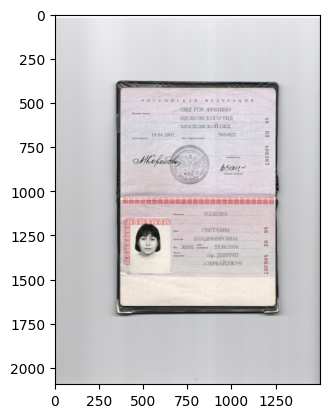

In [43]:
path = '/kaggle/input/docs-gagrin/preparing_data/passport/train/086aba03536ec990b0f02fb261095196.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
# type_, conf, rect = yolo_predict(model, path)[0]
# cropped = crop_image(img, rect)
# cropped = rotate_to_album(cropped)
# res = ocr(cropped)

In [47]:
%%time
work(path)


image 1/1 /kaggle/input/docs-gagrin/preparing_data/passport/train/086aba03536ec990b0f02fb261095196.jpg: 640x480 1 passport_front, 28.1ms
Speed: 2.5ms preprocess, 28.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
CPU times: user 1.63 s, sys: 13.6 ms, total: 1.64 s
Wall time: 1.63 s


[{'type': 'personal_passport',
  'confidence': 0.8968824744224548,
  'series': '4602',
  'number': '406387',
  'page_number': 1}]

In [ ]:
import json
json.dumps(res)